<center>
<h1>Seizure Recognition From EEG Recordings</h1>
</center>

In [1]:
import sys
assert "eeg_tf_clean" in sys.executable, sys.executable

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

/opt/anaconda3/envs/eeg_tf_clean/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Data
https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition

**Attribute Information:**

The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.

We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}.

The response variable is y in column 179, the Explanatory variables X1, X2, …, X178

y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}:

5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

2 - They recorder the EEG from the area where the tumor was located

1 - Recording of seizure activity

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

This Dataset collect from UCI Machine Learning Repository

In [3]:
data = pd.read_csv('data/EpilepticSeizureRecognition.csv')

## EDA

In [4]:
print(data.head())
print(data.describe())
unique_entries = data['Unnamed'].unique()
print(len(unique_entries))

      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]
                 X1            X2            X3            X4            X5  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean     -11.581391    -10.911565    -10.187130  

## Data Cleaning

In [5]:
# drop 'Unnamed' column 
data.drop('Unnamed', axis=1, inplace=True)
# convert every entry that is not 1 to 0 (no seizure detected)
data.loc[data['y'] !=1, 'y'] = 0
data['y'] = data['y'].astype(int)
print(data.head())
print(data['y'].value_counts())

    X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X170  X171  X172  \
0  135  190  229  223  192  125   55   -9  -33  -38  ...   -17   -15   -31   
1  386  382  356  331  320  315  307  272  244  232  ...   164   150   146   
2  -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  ...    57    64    48   
3 -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  ...   -82   -81   -80   
4   -9  -65  -98 -102  -78  -48  -16    0  -21  -59  ...     4     2   -12   

   X173  X174  X175  X176  X177  X178  y  
0   -77  -103  -127  -116   -83   -51  0  
1   152   157   156   154   143   129  1  
2    19   -12   -30   -35   -35   -36  0  
3   -77   -85   -77   -72   -69   -65  0  
4   -32   -41   -65   -83   -89   -73  0  

[5 rows x 179 columns]
y
0    9200
1    2300
Name: count, dtype: int64


<Axes: >

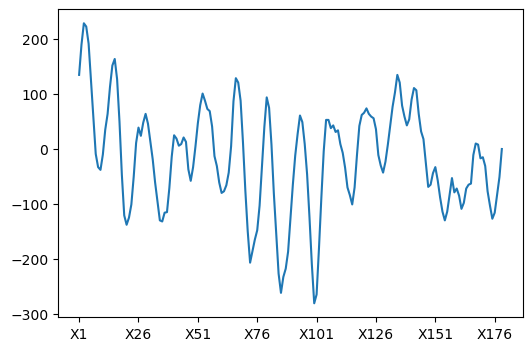

In [6]:
first_row = data.iloc[0]
plt.figure(figsize=(6,4))
first_row.plot(kind='line')

<Axes: >

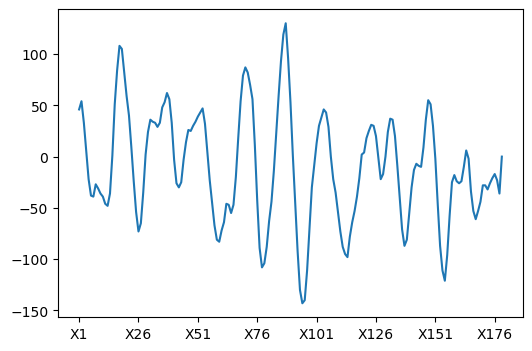

In [7]:
row_100 = data.iloc[99]
plt.figure(figsize=(6,4))
row_100.plot(kind='line')

**Samples will be treated as independent windows due to unavailable subject identifiers.**

Since the data has been processed and 500 subjects × 23 windows it is impossible to determine which entries are from the same subject. 

## Data Normalization

Due to non-neuronal factors there is a large amount of variability signal magnituted from individual to individual. Therefore, each 1-second EEG window will be independently z-score normalized to remove scale differences. 

In [6]:
X = data.drop('y', axis=1).values

X_norm = (X - X.mean(axis=1, keepdims=True))/ (X.std(axis=1, keepdims=True) + 1e-8)

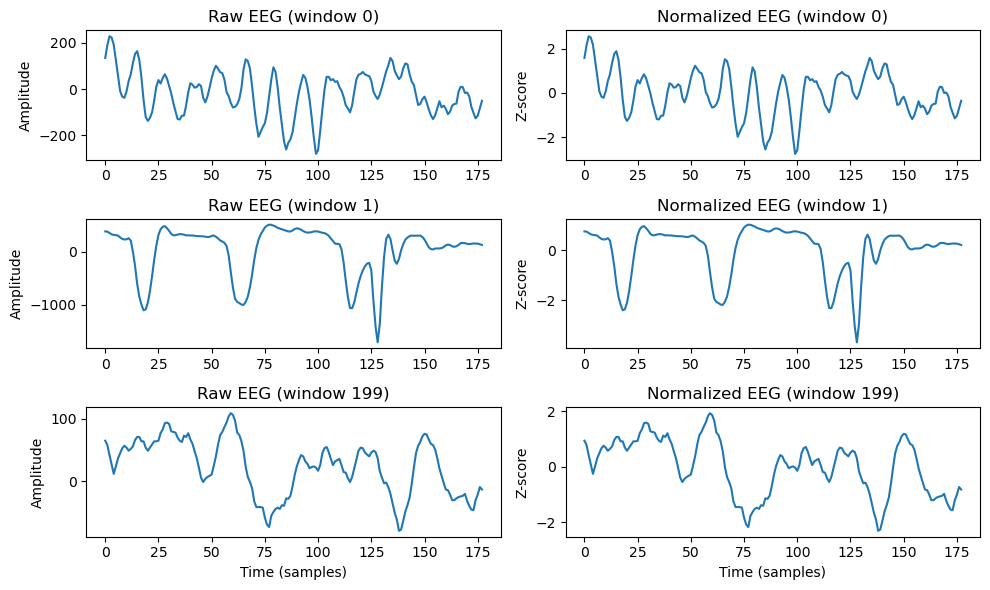

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5,wspace=0.2)

X_raw = data.drop(columns='y').values
# choose example windows
idxs = [0, 1, 199]

for i, idx in enumerate(idxs):
    # raw signal
    axes[i, 0].plot(X_raw[idx])
    axes[i, 0].set_title(f'Raw EEG (window {idx})')
    axes[i, 0].set_ylabel('Amplitude')

    # normalized signal
    axes[i, 1].plot(X_norm[idx])
    axes[i, 1].set_title(f'Normalized EEG (window {idx})')
    axes[i, 1].set_ylabel('Z-score')

axes[-1, 0].set_xlabel('Time (samples)')
axes[-1, 1].set_xlabel('Time (samples)')

plt.tight_layout()
plt.savefig('results/raw_vs_normalized_traces')

plt.show()
           

# Models

## CNN


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  Conv1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.metrics import Recall, AUC

In [9]:
model_1 = Sequential([
    Input(shape=(X.shape[1],1)),
    Conv1D(32, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model_1.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), AUC(name='auc')]
)

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 174, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 174, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 87, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 83, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 83, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 14,913 (58.25 KB)

 Non-trainable params: 192 (768.00 B)

In [10]:
y = data['y']

X_train, X_val, y_train, y_val = train_test_split(
    X_norm, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

In [11]:
# Train the model
history_1 = model_1.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=20, 
                    batch_size=32, 
                    verbose=1); 

Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8943 - auc: 0.9385 - loss: 0.2791 - recall: 0.5359 - val_accuracy: 0.8248 - val_auc: 0.7543 - val_loss: 0.5938 - val_recall: 0.1978
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9628 - auc: 0.9822 - loss: 0.1263 - recall: 0.8652 - val_accuracy: 0.9774 - val_auc: 0.9909 - val_loss: 0.1430 - val_recall: 0.9087
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9734 - auc: 0.9885 - loss: 0.0902 - recall: 0.9043 - val_accuracy: 0.9687 - val_auc: 0.9939 - val_loss: 0.0908 - val_recall: 0.8435
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9752 - auc: 0.9912 - loss: 0.0787 - recall: 0.9179 - val_accuracy: 0.9748 - val_auc: 0.9966 - val_loss: 0.0749 - val_recall: 0.8739
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9792 - auc: 0.9940 - loss: 0.0656 - recall: 0.9283 - val_accuracy: 0.9761 - val_auc: 0.9955 - val_loss: 0.0657 - val_recall: 0.8826
Epoch 6/20

## CNN Model Evaluation

### Plots of Accuracy, Recall, and AUC per Epoch

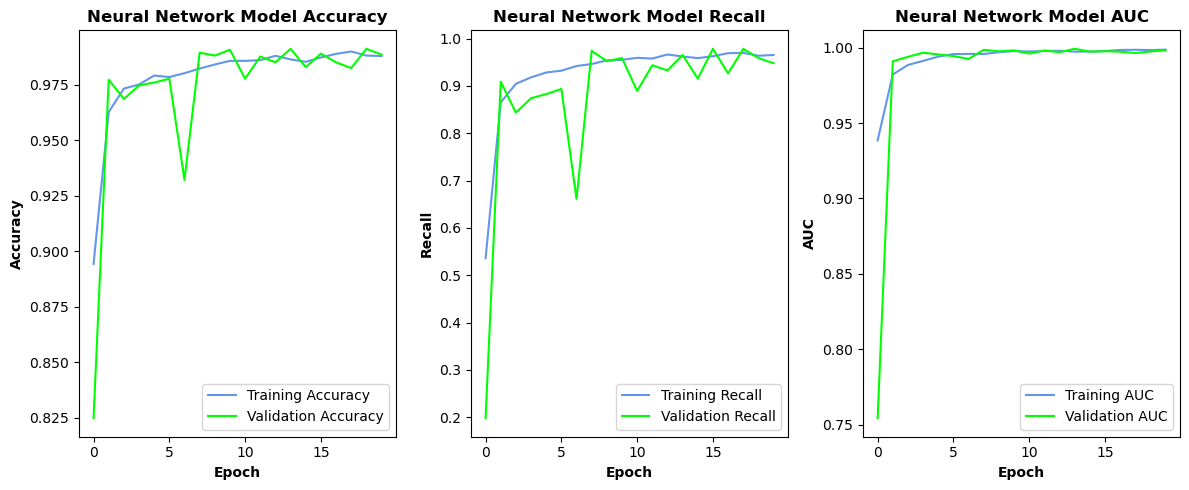

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))

ax[0].plot(history_1.history['accuracy'], color='cornflowerblue', label='Training Accuracy')
ax[0].plot(history_1.history['val_accuracy'], color='lime', label='Validation Accuracy')
ax[0].set_xlabel('Epoch', fontweight='bold')
ax[0].set_ylabel('Accuracy', fontweight='bold')
ax[0].set_title('Neural Network Model Accuracy', fontweight='bold')
ax[0].legend(loc = 'lower right')

ax[1].plot(history_1.history['recall'], color='cornflowerblue', label='Training Recall')
ax[1].plot(history_1.history['val_recall'], color='lime', label='Validation Recall')
ax[1].set_xlabel('Epoch', fontweight='bold')
ax[1].set_ylabel('Recall', fontweight='bold')
ax[1].set_title('Neural Network Model Recall', fontweight='bold')
ax[1].legend(loc = 'lower right')

ax[2].plot(history_1.history['auc'], color='cornflowerblue', label='Training AUC')
ax[2].plot(history_1.history['val_auc'], color='lime', label='Validation AUC')
ax[2].set_xlabel('Epoch', fontweight='bold')
ax[2].set_ylabel('AUC', fontweight='bold')
ax[2].set_title('Neural Network Model AUC', fontweight='bold')
ax[2].legend(loc = 'lower right')

plt.tight_layout()
plt.savefig('results/cnn_model_metrics')
plt.show()



### Confusion Matrix

In [13]:
y_val_probs = model_1.predict(X_val).ravel()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [14]:
threshold = 0.5
y_val_pred = (y_val_probs >= threshold).astype(int)

<Figure size 640x480 with 0 Axes>

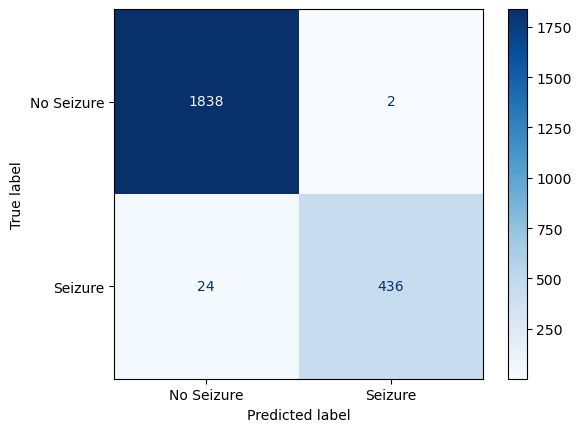

In [17]:
cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Seizure', 'Seizure']
)

plt.tight_layout()
disp.plot(cmap='Blues')
plt.savefig('results/cnn_confusion_matrix.jpg')


The confusion matrix indicates that the model misclassified only 24 out of 460 seizure instances as non-seizure (false negatives), while 2 out of 1,840 non-seizure instances were incorrectly classified as seizures (false positives). This corresponds to a high recall for seizure detection, which is particularly important in clinical applications where minimizing missed seizures is critical.

### Examine Errors

In [16]:
misclassified_index = np.where(y_val != y_val_pred)[0]
print(f"Number of Misclassified Recordings: {len(misclassified_index)}")

Number of Misclassified Recordings: 26


In [18]:
def plot_eeg_trace(trace, title=None):
    """
    function to plot specific eeg traces
    """

    plt.figure(figsize=(8,3))
    plt.plot(trace.squeeze())
    plt.xlabel('Time')
    plt.ylabel('Normalized Amplitude')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


In [19]:
false_negatives = np.where((y_val == 1) & (y_val_pred == 0))[0]
false_positives = np.where((y_val == 0) & (y_val_pred == 1))[0]


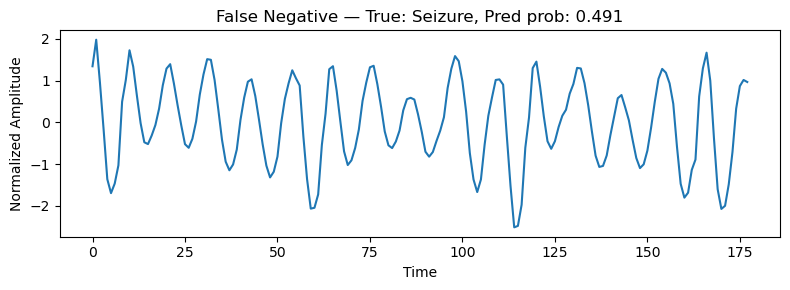

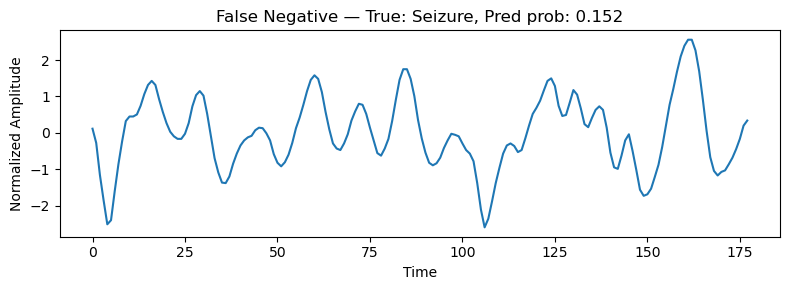

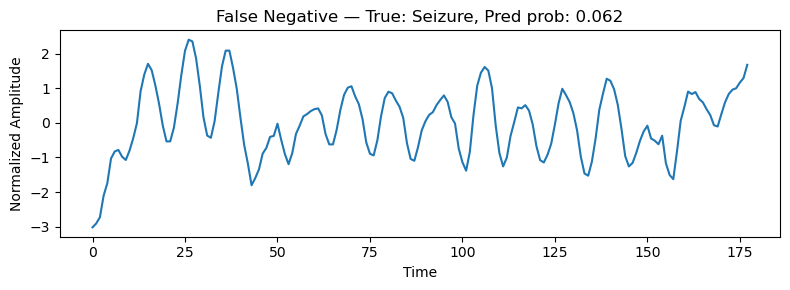

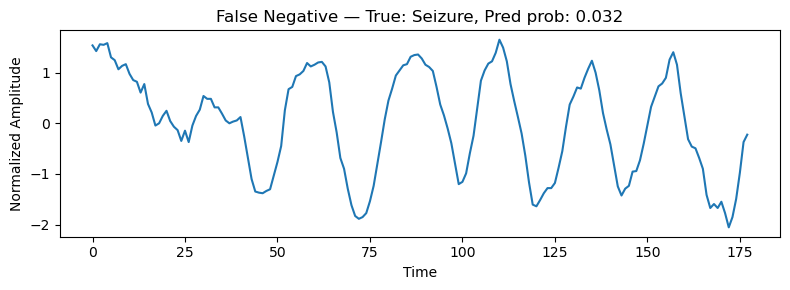

In [20]:
for idx in false_negatives[:4]:
    plot_eeg_trace(
        X_val[idx],
        title=f"False Negative — True: Seizure, Pred prob: {y_val_probs[idx]:.3f}"
    )

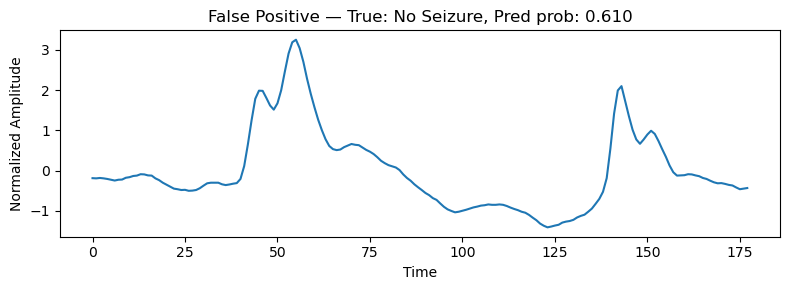

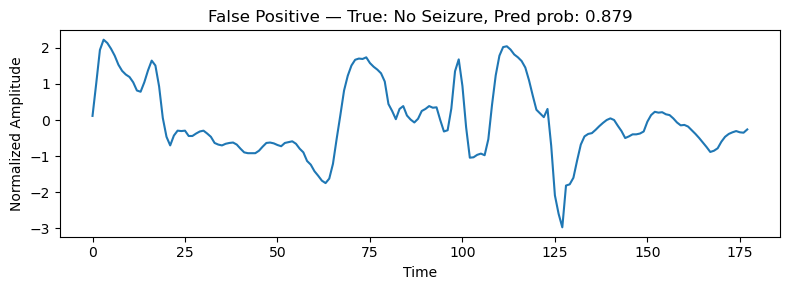

In [22]:
for idx in false_positives[:2]:
    plot_eeg_trace(
        X_val[idx],
        title=f"False Positive — True: No Seizure, Pred prob: {y_val_probs[idx]:.3f}"
    )

In [23]:
false_positive_df = pd.DataFrame({
    'trace_index': false_positives,
    'true_label': 0,
    'predicted_probability': [y_val_probs[idx] for idx in false_positives]
})

false_positive_df['predicted_label'] = 1


In [24]:
false_negative_df = pd.DataFrame({
    'trace_index': false_negatives,
    'true_label': 1,
    'predicted_probability': [y_val_probs[idx] for idx in false_negatives]
})

false_negative_df['predicted_label'] = 0


In [25]:
false_positive_df = false_positive_df.sort_values(
    by='predicted_probability', ascending=False
)

false_negative_df = false_negative_df.sort_values(
    by='predicted_probability', ascending=True
)

print(false_positive_df)
print(false_negative_df)

   trace_index  true_label  predicted_probability  predicted_label
1         1455           0               0.879103                1
0          108           0               0.609636                1
    trace_index  true_label  predicted_probability  predicted_label
12         1032           1               0.001812                0
9           728           1               0.008993                0
11          908           1               0.009897                0
3            71           1               0.032275                0
2            66           1               0.062486                0
8           667           1               0.063837                0
23         2272           1               0.079912                0
21         1938           1               0.081808                0
7           458           1               0.089257                0
16         1249           1               0.112106                0
20         1812           1               0.137230 

In [34]:
false_positive_df.to_csv("results/false_positives.csv")
false_negative_df.to_csv("results/false_negatives.csv")